In [ ]:
#pip install swig

In [ ]:
#pip install -r requirements.txt

In [ ]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import gymnasium as gym
import itertools
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
from typing import List, Tuple, Deque, Optional, Callable

from IPython.display import Image   # To display GIF images in the notebook
import torch.nn.functional as f
from math import fabs
from torch.torch_version import TorchVersion
import torch.optim as optim

In [ ]:
# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Environnement definition

In [ ]:
env = gym.make('CartPole-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()

print(f"State space size is: { state_dim }")
print(f"State upper bounds: { env.observation_space.high }")
print(f"State lower bounds: { env.observation_space.high }")
print(f"Action space size is: { action_dim }")
print("Actions are: {" + ", ".join([str(a) for a in range(env.action_space.n)]) + "}")
env.close()

State space size is: 4
State upper bounds: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
State lower bounds: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Action space size is: 2
Actions are: {0, 1}


In [ ]:
priority_G=0.5
priority_D=0.5

satiation_G=0.5
satiation_D=0.5

k_G = 1 - satiation_G ** (np.tan(priority_G * np.pi / 2))
k_D = 1 - satiation_D ** (np.tan(priority_D * np.pi / 2))

In [ ]:
priority_array=[priority_G,priority_D]
satiation_array=[satiation_G,satiation_D]

priority_tensor=torch.tensor(priority_array)
satiation_tensor = torch.tensor(satiation_array)
satiation_tensor.shape
print(satiation_tensor)

tensor([0.5000, 0.5000])


In [ ]:
class ResourceEnvironment:
    def __init__(self, num_resources_0, num_resources_1):
        # Determine the grid size based on the number of resources
        self.grid_size = int(np.ceil(np.sqrt(num_resources_0 + num_resources_1)))

        # Initialize a grid of zeros
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)

        # Initialize a dictionary to track the type of each resource
        self.resource_map = {}

        # Place resources of type 0 and 1 randomly on the grid
        self._place_resources(num_resources_0, 0)
        self._place_resources(num_resources_1, 1)

        # Randomly place the agent
        self.agent_position = self._place_agent()

    def _place_resources(self, quantity, resource_type):
        count = 0
        while count < quantity:
            x, y = np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)
            if self.grid[x, y] == 0:
                self.grid[x, y] = resource_type
                self.resource_map[(x, y)] = resource_type  # Track the type of resource
                count += 1

    def _place_agent(self):
        while True:
            x, y = np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)
            if self.grid[x, y] == 0:
                return (x, y)

    def get_resource_positions(self):
        return self.resource_map

    def move_agent(self, dx, dy):
        new_x = np.clip(self.agent_position[0] + dx, 0, self.grid_size - 1)
        new_y = np.clip(self.agent_position[1] + dy, 0, self.grid_size - 1)
        self.agent_position = (new_x, new_y)

    def compute_distance(self, target):
        return np.linalg.norm(np.array(self.agent_position) - np.array(target))

# Example usage
env = ResourceEnvironment(14, 8)
print(env.grid)
print("Agent Position:", env.agent_position)
print("Resource Map:", env.get_resource_positions())


[[1 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 1 1]
 [0 1 0 0 1]
 [1 0 0 0 1]]
Agent Position: (1, 1)
Resource Map: {(0, 0): 1, (3, 0): 0, (1, 1): 0, (4, 4): 1, (4, 1): 0, (1, 3): 0, (0, 2): 0, (1, 4): 0, (2, 1): 0, (4, 0): 1, (0, 3): 1, (3, 4): 1, (2, 3): 1, (3, 1): 1, (2, 4): 1}


In [ ]:
def smallest_distance_in_map(env, action):
    act = 1 - action
    resource_positions_of_type = [pos for pos, resource_type in env.get_resource_positions().items() if resource_type == action]

    # Si l'agent est déjà sur une ressource du type recherché
    if env.grid[env.agent_position] == action:
        # L'agent reste sur place et prend l'action
        closest_resource = env.agent_position
        distance_to_closest = 0
    elif not resource_positions_of_type:
        # Si aucune ressource de ce type n'est trouvée, changer le type d'action
        return smallest_distance_in_map(env, act)
    else:
        # Trouver la ressource la plus proche du type recherché
        closest_resource = min(resource_positions_of_type, key=lambda pos: abs(env.agent_position[0] - pos[0]) + abs(env.agent_position[1] - pos[1]))
        distance_to_closest = abs(env.agent_position[0] - closest_resource[0]) + abs(env.agent_position[1] - closest_resource[1])

    env.agent_position = closest_resource
    if closest_resource in env.resource_map:
        del env.resource_map[closest_resource]
        env.grid[closest_resource] = -1

    return action, distance_to_closest


In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self,):
        """
      Attributes
      ----------
      layer1 : torch.nn.Linear
          First fully connected layer.
      layer2 : torch.nn.Linear
          Second fully connected layer.
      layer3 : torch.nn.Linear
          Third fully connected layer.

      Methods
      -------
      forward(x: torch.Tensor, state_tensor : torch.Tensor ) -> torch.Tensor
          Define the forward pass of the QNetwork.
      """
        super(NeuralNetwork, self).__init__()
        # Initialiser les priorités qui resteront fixes
        #self.priority_array = torch.tensor(priority_array, dtype=torch.float32)


        self.layer1 = torch.nn.Linear(27, 72)  # État + satiété
        self.layer2 = torch.nn.Linear(72, 144)
        self.layer3 = torch.nn.Linear(144, 288)
        self.output_layer = torch.nn.Linear(288, 2)  # Deux actions

    def forward(self, satiation_tensor, state_tensor):
        # Concaténer le tenseur de satiété et l'état

        combined_input = torch.cat((satiation_tensor, state_tensor), dim=0)


        # Passer le tenseur combiné à travers les couches
        x = f.relu(self.layer1(combined_input))
        x = f.relu(self.layer2(x))
        x = f.relu(self.layer3(x))
        action_probs = torch.nn.functional.softmax(self.output_layer(x), dim=-1)
        return action_probs



# Graph A - without priority

In [ ]:
graphe_A_nn = NeuralNetwork()

satisfaction_A_levels_action0 = []
satisfaction_A_levels_action1 = []
satisfaction_A_levels_action0.append(0.5)
satisfaction_A_levels_action1.append(0.5)

random_seed = 4
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


def train_network_A(num_episodes, network, satiation_tensor, priority_array, epsilon=0.3):
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    for episode in range(num_episodes):
        # Initialisation des satiations
        satiation_tensor = torch.tensor(satiation_array, dtype=torch.float32)
        satiation_new_tensor = satiation_tensor.clone().detach()
        satiation_cumulative = torch.zeros_like(satiation_tensor)

        # Initialisation de la map
        env = ResourceEnvironment(14, 8)
        flattened_grid = env.grid.flatten()
        state_tensor = torch.tensor(flattened_grid, dtype=torch.float32)


        for i in range(10):  # Pour chaque action dans un épisode
            # Décider si on exploite ou explore
            if random.random() < epsilon:
                # Exploration: choisir une action aléatoire
                action = random.choice([0, 1])
            else:
                # Exploitation: choisir la meilleure action selon le modèle
                with torch.no_grad():
                    action_probs = network(satiation_tensor, state_tensor)
                action = torch.argmax(action_probs).item()

            # Mise à jour de la map et calcul de la distance
            action, distance_action = smallest_distance_in_map(env, action)

            # Changement de satiation
            penalty = 0.00015 * distance_action
            satiation_new_tensor[action] = torch.clamp(satiation_new_tensor[action] + 0.1 - penalty, min=0.0, max=1.0)

            satiation_cumulative += satiation_new_tensor

            #print("satiation_new_tensor",satiation_new_tensor)
            # Calculer le reward et la loss
            reward = satiation_new_tensor[action] - satiation_tensor[action]
            #print(reward)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            # Si on a exploité, calculer la loss basée sur policy gradient
            if random.random() >= epsilon:
                action_probs = network(satiation_tensor, state_tensor)
                action_distribution = torch.distributions.Categorical(action_probs)
                log_prob = action_distribution.log_prob(torch.tensor([action]))
                loss = -log_prob * reward_tensor
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Mise à jour de la satiation moyenne pour cet épisode
        satiation_tensor = satiation_cumulative / 10.0
        #print("pour un episode",satiation_tensor)
        satisfaction_A_levels_action0.append(satiation_tensor[0].item())
        satisfaction_A_levels_action1.append(satiation_tensor[1].item())

    return satisfaction_A_levels_action0, satisfaction_A_levels_action1

# Exemple d'utilisation :
satisfaction_A_levels_action0, satisfaction_A_levels_action1 = train_network_A(250, graphe_A_nn, satiation_tensor, priority_array)



<ipython-input-11-6c028ce75220>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward_tensor = torch.tensor(reward, dtype=torch.float32)


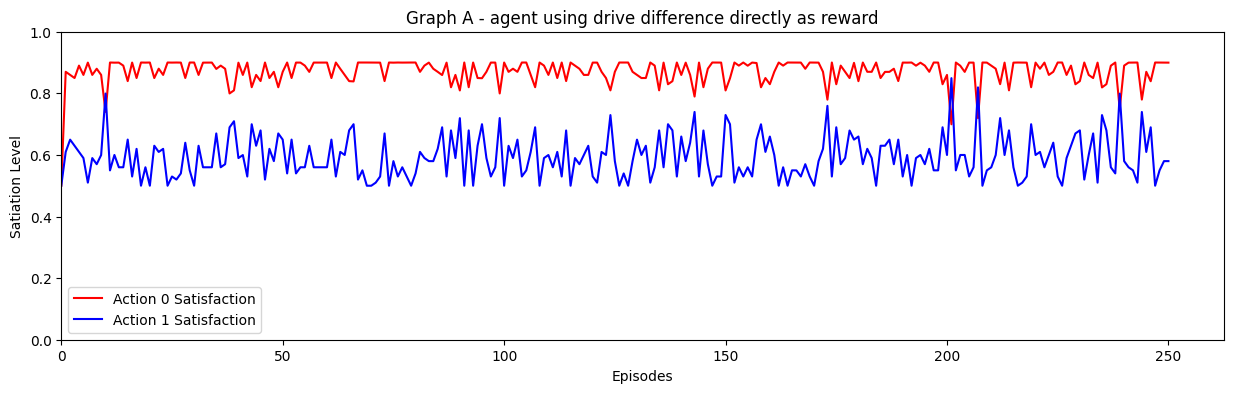

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(satisfaction_A_levels_action0, label='Action 0 Satisfaction', color='red')
plt.plot(satisfaction_A_levels_action1, label='Action 1 Satisfaction', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Satiation Level')
plt.title('Graph A - agent using drive difference directly as reward')
plt.legend()

# Définir les limites pour les axes
plt.xlim(left=0)  # Commencer à 0 pour l'axe des abscisses
plt.ylim(bottom=0)  # Commencer à 0 pour l'axe des ordonnées
plt.ylim(top=1)
plt.show()

# Graph B - Fixed priorities

In [ ]:
graphe_B_nn = NeuralNetwork()
satisfaction_B_levels_action0 = []
satisfaction_B_levels_action1 = []

satisfaction_B_levels_action0.append(0.5)
satisfaction_B_levels_action1.append(0.5)

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)


def train_network_B(num_episodes, network, satiation_tensor, priority_array, epsilon=0.3):
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    for episode in range(num_episodes):
        # Initialisation des satiations
        satiation_tensor = torch.tensor(satiation_array, dtype=torch.float32)
        satiation_new_tensor = satiation_tensor.clone().detach()
        satiation_cumulative = torch.zeros_like(satiation_tensor)

        # Initialisation de la map
        env = ResourceEnvironment(14, 8)
        flattened_grid = env.grid.flatten()
        state_tensor = torch.tensor(flattened_grid, dtype=torch.float32)


        for i in range(10):  # Pour chaque action dans un épisode
            # Décider si on exploite ou explore
            if random.random() < epsilon:
                # Exploration: choisir une action aléatoire
                action = random.choice([0, 1])
            else:
                # Exploitation: choisir la meilleure action selon le modèle
                with torch.no_grad():
                    action_probs = network(satiation_tensor, state_tensor)
                action = torch.argmax(action_probs).item()

            # Mise à jour de la map et calcul de la distance
            action, distance_action = smallest_distance_in_map(env, action)

            # Changement de satiation
            penalty = 0.00015 * distance_action
            satiation_new_tensor[action] = torch.clamp(satiation_new_tensor[action] + 0.1 - penalty, min=0.0, max=1.0)

            satiation_cumulative += satiation_new_tensor

            #print("satiation_new_tensor",satiation_new_tensor)
            # Calculer le reward et la loss
            reward = priority_array[action] * (satiation_new_tensor[action] - satiation_tensor[action])
            #print(reward)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            # Si on a exploité, calculer la loss basée sur policy gradient
            if random.random() >= epsilon:
                action_probs = network(satiation_tensor, state_tensor)
                action_distribution = torch.distributions.Categorical(action_probs)
                log_prob = action_distribution.log_prob(torch.tensor([action]))
                loss = -log_prob * reward_tensor
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Mise à jour de la satiation moyenne pour cet épisode
        satiation_tensor = satiation_cumulative / 10.0
        #print("pour un episode",satiation_tensor)
        satisfaction_B_levels_action0.append(satiation_tensor[0].item())
        satisfaction_B_levels_action1.append(satiation_tensor[1].item())

    return satisfaction_B_levels_action0, satisfaction_B_levels_action1

# Exemple d'utilisation :
satisfaction_B_levels_action0, satisfaction_B_levels_action1 = train_network_B(250, graphe_B_nn, satiation_tensor, priority_array)



<ipython-input-13-144645393d36>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward_tensor = torch.tensor(reward, dtype=torch.float32)


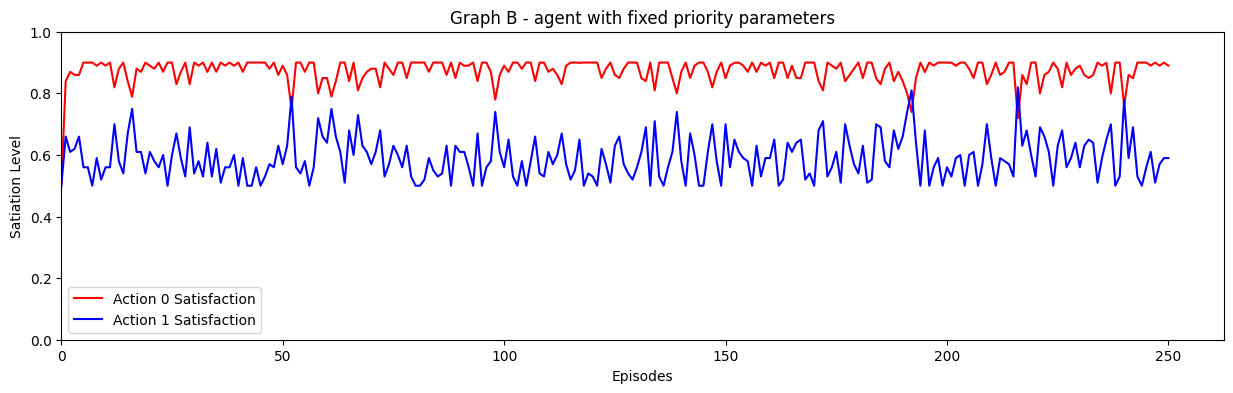

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(satisfaction_B_levels_action0, label='Action 0 Satisfaction', color='red')
plt.plot(satisfaction_B_levels_action1, label='Action 1 Satisfaction', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Satiation Level')
plt.title('Graph B - agent with fixed priority parameters')
plt.legend()

# Définir les limites pour les axes
plt.xlim(left=0)  # Commencer à 0 pour l'axe des abscisses
plt.ylim(bottom=0)  # Commencer à 0 pour l'axe des ordonnées
plt.ylim(top=1)
plt.show()

# Graph C - priority parameter to match observed resource frequency.

In [ ]:
class NeuralNetwork_Priorities(torch.nn.Module):
    def __init__(self,):
        """
      Attributes
      ----------
      layer1 : torch.nn.Linear
          First fully connected layer.
      layer2 : torch.nn.Linear
          Second fully connected layer.
      layer3 : torch.nn.Linear
          Third fully connected layer.

      Methods
      -------
      forward(x: torch.Tensor, state_tensor : torch.Tensor ) -> torch.Tensor
          Define the forward pass of the QNetwork.
      """
        super(NeuralNetwork_Priorities, self).__init__()
        # Initialiser les priorités qui resteront fixes
        #self.priority_array = torch.tensor(priority_array, dtype=torch.float32)


        self.layer1 = torch.nn.Linear(29, 64)  # État + satiété
        self.layer2 = torch.nn.Linear(64, 128)
        self.layer3 = torch.nn.Linear(128, 212)
        self.output_layer = torch.nn.Linear(212, 2)  # Deux actions

    def forward(self, satiation_tensor,state_tensor,priority_tensor):
        # Concaténer le tenseur de satiété et l'état

        combined_input = torch.cat((satiation_tensor, state_tensor,priority_tensor), dim=0)


        # Passer le tenseur combiné à travers les couches
        x = f.relu(self.layer1(combined_input))
        x = f.relu(self.layer2(x))
        x = f.relu(self.layer3(x))
        action_probs = torch.nn.functional.softmax(self.output_layer(x), dim=-1)
        return action_probs



In [ ]:
# Initialize the Neural Network
graph_C_nn = NeuralNetwork_Priorities()

# Initialize the satisfaction levels for both actions
satisfaction_C_levels_action0 = []
satisfaction_C_levels_action1 = []

satisfaction_C_levels_action0.append(0.5)
satisfaction_C_levels_action1.append(0.5)

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Define the train_network_C function with changing priorities and epsilon
def train_network_C(num_episodes, network, satiation_tensor, priority_array, epsilon=0.3):
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    for episode in range(num_episodes):
        # Initialization of satiations
        satiation_tensor = torch.tensor(satiation_array, dtype=torch.float32)
        satiation_new_tensor = satiation_tensor.clone().detach()
        satiation_cumulative = torch.zeros_like(satiation_tensor)

        # Initialize the map
        env = ResourceEnvironment(14, 8)
        flattened_grid = env.grid.flatten()
        state_tensor = torch.tensor(flattened_grid, dtype=torch.float32)

        # Calculate the number of resources of each type
        num_resources_0 = len([pos for pos, resource_type in env.get_resource_positions().items() if resource_type == 0])
        num_resources_1 = len([pos for pos, resource_type in env.get_resource_positions().items() if resource_type == 1])

        # Update priority_array based on the number of resources
        priority_array = torch.tensor([num_resources_0, num_resources_1], dtype=torch.float32)

        for i in range(10):  # For each action in an episode
            # Decide whether to exploit or explore
            if random.random() < epsilon:
                # Exploration: choose a random action
                action = random.choice([0, 1])
            else:
                # Exploitation: choose the best action according to the model
                with torch.no_grad():
                    action_probs = network(satiation_tensor, state_tensor,priority_array)
                action = torch.argmax(action_probs).item()

            # Update the map and calculate distance
            action, distance_action = smallest_distance_in_map(env, action)

            # Change in satiation
            penalty = 0.00015 * distance_action
            satiation_new_tensor[action] = torch.clamp(satiation_new_tensor[action] + 0.1 - penalty, min=0.0, max=1.0)

            satiation_cumulative += satiation_new_tensor

            # Calculate reward and loss
            reward = priority_array[action] * (satiation_new_tensor[action] - satiation_tensor[action])
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            # If exploited, calculate loss based on policy gradient
            if random.random() >= epsilon:
                action_probs = network(satiation_tensor, state_tensor,priority_array)
                action_distribution = torch.distributions.Categorical(action_probs)
                log_prob = action_distribution.log_prob(torch.tensor([action]))
                loss = -log_prob * reward_tensor
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update the average satiation for this episode
        satiation_tensor = satiation_cumulative / 10.0
        satisfaction_C_levels_action0.append(satiation_tensor[0].item())
        satisfaction_C_levels_action1.append(satiation_tensor[1].item())

    return satisfaction_C_levels_action0, satisfaction_C_levels_action1

# Train the network with changing priorities based on the number of resources
satisfaction_C_levels_action0, satisfaction_C_levels_action1 = train_network_C(250, graph_C_nn, satiation_array, priority_array)


<ipython-input-16-ae7f48a4fa6d>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward_tensor = torch.tensor(reward, dtype=torch.float32)


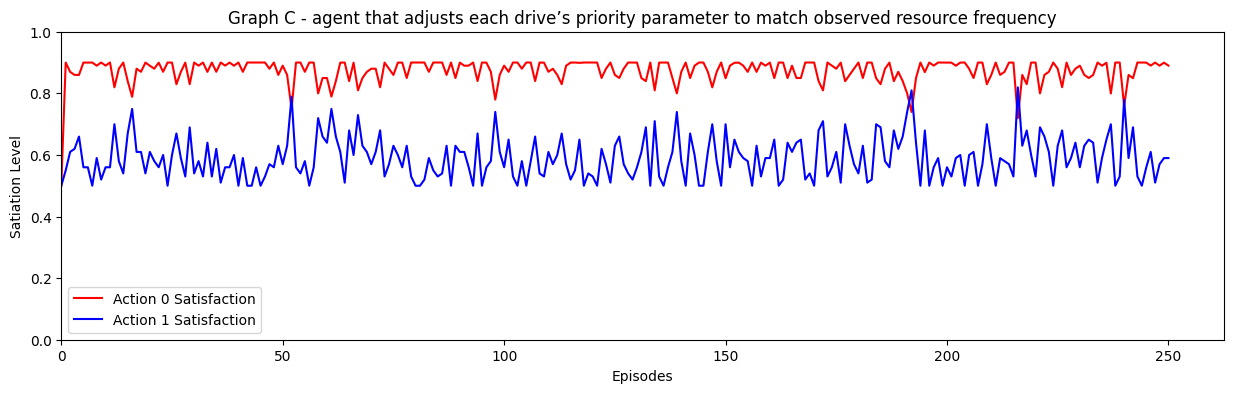

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(satisfaction_C_levels_action0, label='Action 0 Satisfaction', color='red')
plt.plot(satisfaction_C_levels_action1, label='Action 1 Satisfaction', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Satiation Level')
plt.title('Graph C - agent that adjusts each drive’s priority parameter to match observed resource frequency')
plt.legend()

# Définir les limites pour les axes
plt.xlim(left=0)  # Commencer à 0 pour l'axe des abscisses
plt.ylim(bottom=0)  # Commencer à 0 pour l'axe des ordonnées
plt.ylim(top=1)
plt.show()

# Graph D - priority parameters changing over time.
